# Advanced Decision Making in Vending Machine

The third tutorial will be based on the same problem as the second tutorial.

Previously, the rats/users knew what state it was in. Imagine now this information is not available to the rats/users. It is able to make observations of its surroundings so it can estimate likelihoods of being in each state, but does not know for sure.

This is the basis of the next tutorial.

The rats/users holds what is known as a 'belief state', a probability distribution. This is the probability the rats/users thinks it is in each state. Since this is a probability distribution, the sum of all the probabilities must be 1, though there are exceptions that we will talk about later. Brown University, 1999, provides some good information on belief states.

Here is a reminder of the state transitions:

<img src="states.png" width="400" height="400">

### Jupyter Notebook Summary

This tutorial has been produced using Jupyter Notebook. You will sections of text, accompanied by sections of code. To run the code, click on it, hold shift, and press enter.

## Building the Model

### The Code

#### Setting up the experiment

Let's begin writing the code. 

Each section in the tutorial will begin with a block of code, followed by a line by line explanation of the code. The code most likely won't make much sense before reading the explanations.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


class Machine:
    def __init__(self):

        # array for storing reward values
        self.r = np.array([[-1, -10, -30,  -1],   # State S0
                           [-1,  -1, -30,  90],   # State S1
                           [-1,  -1,  -1,  -1],   # State S2
                           [-1,  -1,  -1,  -1]])  # State S3

        # current reward
        self.reward = -1
        
        # keep track of total reward 
        self.total_reward = 0.0

        # list of states
        self.state_list = [0, 1, 2, 3]

        # belief state, all same to start
        self.belief_state = [0.3, 0.3, 0.3, 0.3]  # Choice to be made in s0 and s1

        # set up belief table
        self.belief_table = []

        for s0 in range(0, 11):
            for s1 in range (0, 11):
                for s2 in range (0, 11):
                    for s3 in range (0, 11):
                        self.belief_table.append([s0, s1, s2, s3, 0, 0])

        # convert to array
        self.belief_table = np.vstack(self.belief_table)
        
        # divide all by 10
        self.belief_table = self.belief_table/10.0

        # index of belief table corresponding to belief state
        self.belief_table_index = -1

        # index of belief table corresponding to previous belief state
        self.previous_belief_table_index = -1

        # keep track of real state
        self.real_state = -1

        # action number: 0 = Press lever, 1 = Enter magazine
        self.action_number = -1

        # state to move to next
        self.next_state = -1
        
        # keep track of expected value
        self.expected_value_array = []

The first three lines are the same imports as the first two tutorials.

    np.set_printoptions(suppress=True)
    
This suppresses scientific notation when printing, for example, instead of printing 1.62300000e+03, 1623 will be printed.

Like before, a class is created next. Classes hold functions that we will create. We have named our class 'Machine'.

An initial '\__init\__' function has been created. This is used to set up the experiment initially.

    self.r = np.array([[-1,  -10,  -30,   -1],   # State S0
                       [-1,   -1,  -30,   90],   # State S1
                       [-1,   -1,   -1,   -1],   # State S2
                       [-1,   -1,   -1,   -1]])  # State S3

This sets up the reward array the same way as the second tutorial.

    self.reward = -1
    
This will hold a reward value that we get from the table when we move to a new state.

    self.total_reward = 0.0
        
This will be used to keep track of total reward achieved throughout the experiment.

    self.state_list = [0, 1, 2, 3]
    
This is a list of states.

    self.belief_state = [0.3, 0.3, 0.3, 0.3]
    
This is the belief state that we spoke about earlier. We start at having equal beliefs for each state, i.e. [0.25, 0.25, 0.25, 0.25], but we will be rounding everything to 1 decimal place, so these each get rounded up to 0.3. This is an example of an exception that we spoke about, where the sum is over 1.

    self.belief_table = []

    for s0 in range(0, 11):
        for s1 in range (0, 11):
            for s2 in range (0, 11):
                for s3 in range (0, 11):
                    self.belief_table.append([s0, s1, s2, s3, 0, 0])
                    
    self.belief_table = np.vstack(self.belief_table)

    self.belief_table = self.belief_table/10.0


With each individual belief state, there are Q-values for each action that can be taken in that state. In our experiment, the two actions are 'Press lever' and 'Enter magazine', which we will refer to as A0 and A1 respectively. 

We will use a 'belief table' to store belief states along with these Q-values. This means that a single entry in this table will be [Probability in S0, Probability in S1, Probability in S2, Probability in S3, Q-value for A0, Q-value for A1].

For example, entries could be: [0.4, 0.2, 0.3, 0.1, 20, 10] or [0.1, 0.5, 0.2, 0.2, 5, 30].

We create an entry for every probability of 1 decimal place, ranging from 0.0 to 1.0 for each of the four states, and set the initial Q-values for A0 and A1 to 0. Here is a breakdown of the above code:

    self.belief_table = []

We create an empty list which we will populate.

    for s0 in range(0, 11):
        for s1 in range (0, 11):
            for s2 in range (0, 11):
                for s3 in range (0, 11):
                    self.belief_table.append([s0, s1, s2, s3, 0, 0])
                    

This is an example of a nested 'for' loop. You should understand how basic 'for' loops work from the previous tutorials. Like normal 'for' loops, the inner code must be completed for the loop to increment by one. Therefore, for an outer 'for' loop to increment, all the inner code must be completed. Here's a more basic example to help:

    example_list = []

    for s0 in range (0, 3):
        for s1 in range (0, 3):
            self.example_list.append([s0, s1, 0])
            
This returns the result: [[0, 0, 0], [0, 1, 0], [0, 2, 0], [0, 3, 0], [1, 0, 0], [1, 1, 0], [1, 2, 0], [1, 3, 0], [2, 0, 0], [2, 1, 0], [2, 2, 0], [2, 3, 0], [3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 3, 0]]

This will append a list [s1, s2, 0] after each iteration of a loop.


This creates all the entries in the belief table, matching all possible belief states, though using integers from 0 to 10 rather than 0.0 to 1.0. We originally use integers as we cannot use floats with 'for' loops.

    self.belief_table = np.vstack(self.belief_table)

This makes the changes the belief table from a list to an array, which will be easier for us later.

    self.belief_table = self.belief_table/10.0
    
This divides all the entries by 10, reducing the range from 0 to 10, to 0.0 to 1.0, giving our final belief table.

There are some entries that are not possible, such as [0.5, 0.5, 0.5, 0.5], as that entry sums to 2, but this is an easy way of creating the belief table, and we can just ignore and not use the entries that we don't need or are not possible.

    self.belief_table_index = -1
    
This keeps track of which entry in the belief table matches our belief state. 

For example, if the belief state is [0.3, 0.4, 0.2, 0.1], it will be used to store the index of the element in the belief table that contains the Q-values for A0 and A1 when this is the belief state, i.e. the index of the entry [0.3, 0.4, 0.2, 0.1, Q-value for A0, Q-value of A1].

    self.previous_belief_table_index = -1

This keeps track of the previous index. It will be used when we update the Q-values later.

    self.real_state = -1
    
This is used to keep track of the real state that the rat is in.

    self.action_number = -1 

This is used to keep track of the action number chosen, A0 or A1.

    self.next_state = -1

The action number, together with the current state, will be used to calculate the next state.

    self.expected_value_array = []
    
We will keep track of how the expected value changes over the course of the experiment.

#### Reset

The reset function resets some values back to the original values. We will use it later.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


class Machine:
    
    from code import __init__

    def reset(self, initial_state):

        print "Reset"

        self.belief_state = [0.3, 0.3, 0.3, 0.3]
        self.real_state = initial_state
        
experiment_instance = Machine()
experiment_instance.belief_state = [0.4, 0.2, 0.1, 0.3]
experiment_instance.real_state = 2

print "Before reset"
print experiment_instance.belief_state
print experiment_instance.real_state

print ""
experiment_instance.reset(0)

print experiment_instance.belief_state
print experiment_instance.real_state

Before reset
[0.4, 0.2, 0.1, 0.3]
2

Reset
[0.3, 0.3, 0.3, 0.3]
0


    from code import __init__

As in the first and second tutorials, we've added this to our code. We have a separate file, 'code.py', that contains all the functions we will write. We wrote '\__init\__' in the previous section. To save space, we can replace the entire '\__init\__' with 'from code import \__init\__', which takes '\__init\__' from code.py and puts it where the import line is.

We will be adding more functions to this line throughout the tutorial. Functions can be added by separating them with a comma.

    def reset(self, initial_state):

We need the initial state as a parameter, so we know what to reset the state to.

    self.belief_state = [0.3, 0.3, 0.3, 0.3]
    self.real_state = initial_state
    
We will use this function when the rat reaches a terminal state. These values are set back to what they were at the beginning, ready for a new run.

Run the code to see how reset affects variables after it is run.

#### Making an observation

As explained earlier, the rat can make an 'observation', which helps give an indication as to what state it is in. However, the rat cannot be sure its observation is correct. 


We model this by giving a chance of returning the real state that the rat is in when it performs an observation, otherwise an incorrect state will be returned. The chance it returns the correct state is known as the 'Observation Chance'.

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


class Machine:
    
    from code import __init__, reset    
    
    def observe(self, observation_chance):

        rand_num = random.random()
        if rand_num < observation_chance:
            return self.real_state
        else:
            random_state = random.choice(self.state_list)
            
            while random_state == self.real_state:
                random_state = random.choice(self.state_list)
                
            return random_state
        
experiment_instance = Machine()
experiment_instance.real_state = 0

observation_chance = 0.65
for n in range(0, 10):
    observation = experiment_instance.observe(observation_chance)
    print "State observed: ", observation

State observed:  0
State observed:  0
State observed:  0
State observed:  0
State observed:  0
State observed:  3
State observed:  0
State observed:  1
State observed:  0
State observed:  0


This function is quite simple.

    def observe(self, observation_chance)

We need the observation chance. This is the chance the observation returns the correct state.

    rand_num = random.random()

This generates a random float between 0.0 and 1.0.

    if rand_num < observation_chance:
        return self.real_state

If the random number is less than the observation chance, then the observation is 'correct' and returns the real state.

    else:
        random_state = random.choice(self.state_list)

If the random number is not less than the observation chance, we select a random state from the state list.

    while random_state == self.real_state:
            random_state = random.choice(self.state_list)

While this random_state is equal to the real state, we select a new random state. This stops the real state being returned, so if the observation 'fails', only an incorrect state can be returned.

    return random_state

We return this state.

Running the above code will perform 10 observations while the rat is in S0. Run the code a few times to see the distribution of results. We've set the observation chance to 0.65 for this example.

#### Updating the belief state

After the observation we need to update the belief state. We will do this using Bayes' rule:

$$P(S_{j} | O_{k}) = \dfrac {P(O_{k} | S_{j}) \cdot P(S_{j-1})}{N}$$

$P(S_{j} | O_{k})$ is the probability of the rat being in state j, given that the observation has returned k.

In order to calculate this, we use Bayes' rule, which rewrites it in a way we can calculate.

$P(O_{k} | S_{j})$ is the probability of observing k given that we are in state j. 

In our example, if given that the rat is in state 0, the chance of observing state 0 is our observation chance (0.65 in this example).

If given that that the rat is in state 0, the chance of observing another state (1, 2 or 3) is 1 - observation chance.
The chance of observing state 1 specifically is (1 - observation chance)/(total number of states - 1). The same applies to state 2 or 3.

$P(S_{j-1})$ is the prior belief, the belief state before the  new observation.

We divide by $N$, a normalising factor in order to make sure the probabilities sum to 1.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


class Machine:
    
    from code import __init__, reset, observe  
    
    def update_belief_state(self, observation_state, observation_chance):

        # Temporary list
        temp_belief_state = [0.0, 0.0, 0.0, 0.0]

        # Use Bayes' Rule to update belief state
        for n in range(len(temp_belief_state)):
            if observation_state == n:
                temp_belief_state[n] = observation_chance * self.belief_state[n]
            else:
                temp_belief_state[n] = ((1 - observation_chance)/(len(self.state_list) - 1)) * self.belief_state[n]
                
        print "Before normalising ", temp_belief_state

        # Normalise so the belief state sums to 1
        temp_total = sum(temp_belief_state)
        self.belief_state = list(n/temp_total for n in temp_belief_state)

        # Round to 1 decimal place
        self.belief_state = [round(n, 1) for n in self.belief_state]

        print "After update: ", self.belief_state
        
experiment_instance = Machine()
experiment_instance.real_state = 0

observation_chance = 0.65
observation = experiment_instance.observe(observation_chance)
print "Observation: ", observation
experiment_instance.update_belief_state(observation, observation_chance)

observation = experiment_instance.observe(observation_chance)
print "\nObservation: ", observation
experiment_instance.update_belief_state(observation, observation_chance)

Observation:  0
Before normalising  [0.195, 0.034999999999999996, 0.034999999999999996, 0.034999999999999996]
After update:  [0.7, 0.1, 0.1, 0.1]

Observation:  0
Before normalising  [0.45499999999999996, 0.011666666666666665, 0.011666666666666665, 0.011666666666666665]
After update:  [0.9, 0.0, 0.0, 0.0]


Let's see how this works.

    def update_belief_state(self, observation_state, observation_chance)
    
This function needs the observation and observation chance as parameters.

    temp_belief_state = [0.0, 0.0, 0.0, 0.0]
    
We create a temporary belief state list that we will be changing.

    for n in range(len(temp_belief_state)):
        if observation_state == n:
            temp_belief_state[n] = observation_chance * self.belief_state[n]
        else:
            temp_belief_state[n] = ((1 - observation_chance)/(len(self.state_list) - 1)) * self.belief_state[n]
    
We loop through the temp_belief_state list, and update all states using the first part of Bayes' rule: $P(O_{k} | S_{j}) \cdot P(S_{j-1})$

    if observation_state == n:
        temp_belief_state[n] = observation_chance * self.belief_state[n]

If we are updating the belief the state returned by the observation.

$P(O_{k} | S_{j})$ is the observation chance, as explained above.

$P(S_{j-1})$ is self.belief_state[n], the prior belief. This gets the current belief that we are in that particular state (the belief before we've updated it). In this case, it will always be 0.3, as we've reset the belief state to [0.3, 0.3, 0.3, 0.3]

    else:
        temp_belief_state[n] = ((1 - observation_chance)/(len(self.state_list) - 1)) * self.belief_state[n]
        
If we are updating the belief of a state that is not the observed state:

$P(O_{k} | S_{j})$ is (1 - the observation chance) divided by (len(self.state_list) - 1), as explained above.

$P(S_{j-1})$ is self.belief_state[n], the same as explained above.

The next section calculates $N$ and normalises the belief state.
    
    temp_total = sum(temp_belief_state)
    
This is sum of all the elements in temp_belief_state, and is the normalising factor $N$.

    self.belief_state = list(x/temp_total for x in temp_belief_state)
    
We divide every element in temp_belief_state by $N$, meaning temp_belief_state will sum to 1, and assign to belief_state.

    self.belief_state = [round(x, 1) for x in self.belief_state]
    
We round all the elements in our belief state to 1 decimal place.

Run the above code a few times to see the belief state update.

The code will set the the real state to 0, perform an observation, update the belief state, perform another observation, and update the belief state again.

If you change the way the belief state is reset, you may find that it is the case that the belief state does not sum to 1, as stated earlier. An example of this is [0.9, 0.0, 0.0, 0.0]. 

The real values may be [0.88, 0.04, 0.04, 0.04], which sums to 1, but after rounding to 1 decimal place, it becomes [0.9, 0.0, 0.0, 0.0]. 

#### Choosing the next action

This section of code will choose the next action. We use the epsilon-greedy algorithm that we covered in first tutorial, and used again in the second tutorial.

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

class Machine:

    from code import __init__, reset, observe, update_belief_state

    def choose_next_action(self, epsilon):

        # get the q_values of the two actions
        q_value_a0 = (self.belief_table[self.belief_table_index, 4])

        q_value_a1 = (self.belief_table[self.belief_table_index, 5])

        # choose an action using epsilon-greedy
        rand_num = random.random()

        if q_value_a0 > q_value_a1:

            if rand_num > epsilon: 
                self.action_number = 0  # Exploit

            else:  
                self.action_number = 1  # Explore

        elif q_value_a1 > q_value_a0:

            if rand_num > epsilon:
                self.action_number = 1  # Exploit

            else:
                self.action_number = 0  # Explore

        else:
            self.action_number = random.randint(0, 1)
            
        print "Action chosen: ", self.action_number
        
experiment_instance = Machine()
experiment_instance.belief_table_index = 100
experiment_instance.belief_table[experiment_instance.belief_table_index, 4] = 10
experiment_instance.belief_table[experiment_instance.belief_table_index, 5] = 20
print experiment_instance.belief_table[experiment_instance.belief_table_index]

epsilon = 0.1
for n in range(10):
    experiment_instance.choose_next_action(epsilon)

[  0.    0.    0.9   0.1  10.   20. ]
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1
Action chosen:  1


    def choose_next_action(self, epsilon):
    
We need the epsilon value as a parameter.

    q_value_a0 = (self.belief_table[self.belief_table_index, 4])
    
Remember that each element in the belief table is laid out in the format:

[Probability in S0, Probability in S1, Probability in S2, Probability in S3, Q-value for A0, Q-value for A1].

The above line of code will get the value in the 4th position, which is the Q-value for A0 (Press lever).

    q_value_a1 = (self.belief_table[self.belief_table_index, 5])
    
This similarly get the Q-value for A1 (Enter magazine).

    rand_num = random.random()
    
Generate a random float between 0.0 and 1.0 to use in our epsilon-greedy function.

    if q_value_a0 > q_value_a1:

        if rand_num > epsilon:
            self.action_number = 0  # Exploit

        else:
            self.action_number = 1  # Explore
            
If the Q-value for A0 is higher than the Q-value for A1:

If the random number generated is higher than the epsilon value, we exploit, choosing A0, pressing the lever (the action we think is better).

If it is lower, we explore, choosing A1, entering the magazine (the action we think it worse).

    elif q_value_a1 > q_value_a0:

        if rand_num > epsilon:
            self.action_number = 1  # Exploit

        else:
            self.action_number = 0  # Explore
            
We do the same thing, but with the actions reversed if the Q-value for A1 is higher than the Q-value for A0.

    else:
        self.action_number = random.randint(0, 1)
        
Otherwise, the Q-values are equal, so we just randomly select an action.

Running the code will set the Q-values of A0 and A1 for an arbitrary element (100) in belief_table to 10 and 20 respectively.

The choose_next_action function will be run 10 times, with an epsilon value of 0.1, and an action will be picked. A1 should be picked significantly more than A0.

#### Getting the next state

This function is used to get the next state once we have the action number.

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

class Machine:

    from code import __init__, reset, observe, update_belief_state, choose_next_action

    # get corresponding next state from current state and action number
    def get_next_state(self):

        if self.real_state == 0:

            if self.action_number == 0:

                self.next_state = 1

            elif self.action_number == 1:

                self.next_state = 2

        elif self.real_state == 1:

            if self.action_number == 0:

                self.next_state = 2

            elif self.action_number == 1:

                self.next_state = 3
                
        print "Current state: ", self.real_state
        
        print "Action number: ", self.action_number

        print "Next state: ", self.next_state


experiment_instance = Machine()
experiment_instance.real_state = 0
experiment_instance.action_number = 0
experiment_instance.get_next_state()

print ""
experiment_instance.real_state = 1
experiment_instance.action_number = 1
experiment_instance.get_next_state()

Current state:  0
Action number:  0
Next state:  1

Current state:  1
Action number:  1
Next state:  3


    def get_next_state(self):
    
We don't need any additional parameters other than the experiment instance.

    if self.real_state == 0:

        if self.action_number == 0:

            self.next_state = 1

        elif self.action_number == 1:

            self.next_state = 2

Take a look at the image at the start of this tutorial to remind yourself of the state transitions.

The code is pretty self-explanatory. If the current state is 0, and the rat has chosen A0 (pressing the lever), the rat moves into state 1. If the current state is 0, and the rat has chosen A1 (entering the magazine), the rat moves into state 2.

    elif self.real_state == 1:

        if self.action_number == 0:

            self.next_state = 2

        elif self.action_number == 1:

            self.next_state = 3
            
This adds the correct next_state calculations if the rat is currently in S1.

Running the code will get the next state if the current state is 0 and action 0 is chosen, and if the current state is 1 and action 1 is chosen.

#### Getting the correct index of the belief table

This function gets the index in the belief table that corresponds to the belief state, i.e. if the belief state is [0.3, 0.3, 0.2, 0.2], this function will get the index of the belief table for the entry [0.3, 0.3, 0.2, 0.2, Q-value for A0, Q-value for A1].

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

class Machine:

    from code import __init__, reset, observe , update_belief_state, choose_next_action, get_next_state
    
    def get_belief_table_index(self):

        self.belief_table_index = np.where((self.belief_table[:, 0] == self.belief_state[0])
                                           & (self.belief_table[:, 1] == self.belief_state[1])
                                           & (self.belief_table[:, 2] == self.belief_state[2])
                                           & (self.belief_table[:, 3] == self.belief_state[3]))[0]
        
        print "Index: ", self.belief_table_index
        
experiment_instance = Machine()
experiment_instance.belief_state = [0.0, 0.0, 0.0, 0.0]
print "Belief state: ", experiment_instance.belief_state
experiment_instance.get_belief_table_index()
print "Belief table entry ", experiment_instance.belief_table_index, ": ", experiment_instance.belief_table[experiment_instance.belief_table_index]

experiment_instance.belief_state = [0.3, 0.4, 0.2, 0.1]
print "\nBelief state: ", experiment_instance.belief_state
experiment_instance.get_belief_table_index()
print "Belief table entry ", experiment_instance.belief_table_index, ": ", experiment_instance.belief_table[experiment_instance.belief_table_index]

experiment_instance.belief_state = [0.6, 0.3, 0.1, 0.0]
print "\nBelief state: ", experiment_instance.belief_state
experiment_instance.get_belief_table_index()
print "Belief table entry ", experiment_instance.belief_table_index, ": ", experiment_instance.belief_table[experiment_instance.belief_table_index]

Belief state:  [0.0, 0.0, 0.0, 0.0]
Index:  [0]
Belief table entry  [0] :  [[ 0.  0.  0.  0.  0.  0.]]

Belief state:  [0.3, 0.4, 0.2, 0.1]
Index:  [4500]
Belief table entry  [4500] :  [[ 0.3  0.4  0.2  0.1  0.   0. ]]

Belief state:  [0.6, 0.3, 0.1, 0.0]
Index:  [8360]
Belief table entry  [8360] :  [[ 0.6  0.3  0.1  0.   0.   0. ]]


    self.belief_table_index = np.where((self.belief_table[:, 0] == self.belief_state[0])
                                           & (self.belief_table[:, 1] == self.belief_state[1])
                                           & (self.belief_table[:, 2] == self.belief_state[2])
                                           & (self.belief_table[:, 3] == self.belief_state[3]))[0]

This function consists of just this line.

We use the 'where' function in the numpy library. We get the index where all four values in the belief state match the first four values of the entry in the belief table exactly.

It does this by finding the entry in the belief table where the first element of the entry matches the first element of the belief state, the second element of the entry matches the second element of the belief state, the third element of the entry matches the third element of the belief state, and the fourth element of the entry matches the fourth element of the belief state.`

Running the code will get the index of the belief table corresponding to the belief states: [0.0, 0.0, 0.0, 0.0], [0.3, 0.4, 0.2, 0.1], and [0.6, 0.3, 0.1, 0.0]

#### Updating the belief table

Here, we update the Q-values after taking an action.

Here's a reminder of the Q-learning algorithm we learnt in the second tutorial:

$$Q(s_{t}, a_{t}) \gets Q(s_{t}, a_{t}) + \alpha \cdot (r_{t+1} + \gamma \cdot maxQ(s_{t+1}, a) - Q(s_{t}, a_{t}))$$

where $\alpha$ is the learning rate, and $\gamma$ is the discount factor.

The above is taken from Sutton and Barto, 1998, pp.148, which is a good resource on reinforcement learning.

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

class Machine:
    
    from code import __init__, reset, observe, update_belief_state, choose_next_action, get_next_state, get_belief_table_index
    
    # get highest Q-value in belief state
    def calculate_max_q_value(self):

        # get the Q-values of the two actions
        q_value_a0 = self.belief_table[self.belief_table_index, 4]

        q_value_a1 = self.belief_table[self.belief_table_index, 5]

        # return the highest
        if q_value_a0 > q_value_a1:
            return q_value_a0
        else:
            return q_value_a1

    def update_belief_table(self, alpha, gamma):

        # get correct element index for the select action
        if self.action_number == 0:
            location = 4
        else:
            location = 5

        max_q_value = self.calculate_max_q_value()

        previous_q = self.belief_table[self.previous_belief_table_index, location]

        print "Real state: ", self.real_state
        print "Action number: ", self.action_number
        print "Max Q: ", max_q_value
        print "Reward: ", self.reward

        print "Before update: ", self.belief_table[self.previous_belief_table_index]

        # update Q-value
        self.belief_table[self.previous_belief_table_index, location] = previous_q + alpha * (self.reward + gamma * max_q_value - previous_q)

        # round to 1 decimal place
        self.belief_table[self.previous_belief_table_index, location] = round(self.belief_table[self.previous_belief_table_index, location], 1)

        print "After update: ", self.belief_table[self.previous_belief_table_index]
        
experiment_instance = Machine()
experiment_instance.real_state = 1
experiment_instance.action_number = 1
experiment_instance.reward = 90
experiment_instance.previous_belief_table_index = 100
experiment_instance.belief_table_index = 200
experiment_instance.belief_table[100] = [0.3, 0.3, 0.2, 0.2, 10, 20]
experiment_instance.belief_table[200] = [0.2, 0.2, 0.1, 0.5, 40, 30]

experiment_instance.update_belief_table(0.1, 0.8)

Real state:  1
Action number:  1
Max Q:  40.0
Reward:  90
Before update:  [  0.3   0.3   0.2   0.2  10.   20. ]
After update:  [  0.3   0.3   0.2   0.2  10.   30.2]


The above code may require some horizontal scrolling, depending on your monitor size.

We will be doing this function slightly differently to the second tutorial. We will be moving to the next state, performing a new observation and updating the belief state before updating the Q-value for the previous belief state and action chosen. This is so we are able to calculate the the max Q-value in the next belief state accurately, as we don't know what the next belief state is until we actually make the move and make another observation.

We start by creating a function to calculate the max Q-value in the state.

    # get highest Q-value in belief state
    def calculate_max_q_value(self):

        # get the Q-values of the two actions
        q_value_a0 = self.belief_table[self.belief_table_index, 4]

        q_value_a1 = self.belief_table[self.belief_table_index, 5]

        # return the highest
        if q_value_a0 > q_value_a1:
            return q_value_a0
        else:
            return q_value_a1

This function is simple, it gets the values for A0 and A1 in the current state, compares them and returns the highest.

    def update_belief_table(self, alpha, gamma):
    
Now we update the Q-value in the belief table. This function takes in alpha and gamma as parameters.

    if self.action_number == 0:
            location = 4
        else:
            location = 5

We get the location of the Q-value for the chosen action in the belief table. Entries are in the format: [Probability in S0, Probability in S1, Probability in S2, Probability in S3, Q-value for A0, Q-value for A1], so if A0 has been chosen, the location is set to 4, otherwise it is set to 5.

    max_q_value = self.calculate_max_q_value()
    
We calculate the maximum Q-value using the previous function discussed.

    previous_q = self.belief_table[self.previous_belief_table_index, location]

We get the Q-value for the previous belief state and the action chosen - the Q-value we will be updating.

previous_belief_table_index is the the index of belief_table that matches the previous belief_state. We assign and update this later.

    self.belief_table[self.previous_belief_table_index, location] = previous_q + alpha * (self.reward + gamma * max_q_value - previous_q)
    
We update the Q-value using the algorithm we learnt in the second tutorial.

    self.belief_table[self.previous_belief_table_index, location] = round(self.belief_table[self.previous_belief_table_index, location], 1)
    
We round this updated Q-value to 1 decimal place.

Run the above code. We insert some arbitrary values so you can see how the update works.

#### Running the experiment

This is the code we will use to run the experiment. It is quite long, but straightforward.

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

class Machine:
    
    from code import __init__, reset, observe, update_belief_state, choose_next_action, get_next_state, get_belief_table_index, calculate_max_q_value, update_belief_table

    def run_experiment(self, initial_state, observation_chance, alpha, gamma, epsilon, num_runs_wanted):

        # set current state to initial state wanted
        self.real_state = initial_state

        # make an initial run

        # make an observation
        observation = self.observe(observation_chance)

        # update belief state with observation
        self.update_belief_state(observation, observation_chance)

        # get the corresponding index in the belief table
        self.get_belief_table_index()

        # choose next action
        self.choose_next_action(epsilon)

        # get the next state
        self.get_next_state()

        # get the reward for moving from current state to next state
        self.reward = self.r[self.real_state][self.next_state]

        # update total reward
        self.total_reward += self.reward

        # move to the next state
        self.real_state = self.next_state
        self.belief_state = [0.3, 0.3, 0.3, 0.3]

        print "Real state update: ", self.real_state, " --> ", self.next_state

        # variables to keep track
        num_rewards_received = 0
        num_fails = 0

        num_runs = 0

        while num_runs < num_runs_wanted:

            print ""

            # make an observation
            observation = self.observe(observation_chance)

            # update belief state with observation
            self.update_belief_state(observation, observation_chance)

            # keep track of the previous belief_table_index
            self.previous_belief_table_index = self.belief_table_index

            # get the corresponding index in the belief table
            self.get_belief_table_index()

            print "Observation: ", observation

            # update the belief table using Q-learning
            self.update_belief_table(alpha, gamma)

            # if terminal state reached
            if self.real_state == 2 or self.real_state == 3:

                if self.real_state == 2:
                    num_fails += 1
                elif self.real_state == 3:
                    num_rewards_received += 1

                num_runs += 1

                self.expected_value_array = np.append(self.expected_value_array, self.total_reward / (80 * num_runs))

                # reset to inital values
                self.reset(initial_state)

                # make an observation
                observation = self.observe(observation_chance)

                # update belief state with observation
                self.update_belief_state(observation, observation_chance)

                print "Observation: ", observation

                # get the corresponding index in the belief table
                self.get_belief_table_index()

                # keep track of the previous belief_table_index
                self.previous_belief_table_index = self.belief_table_index

            # choose next action
            self.choose_next_action(epsilon)

            # get the next state
            self.get_next_state()

            # get the reward for moving from current state to next state
            self.reward = self.r[self.real_state][self.next_state]

            # update total reward
            self.total_reward += self.reward

            print "Real state update: ", self.real_state, " --> ", self.next_state

            # move to the next state
            self.real_state = self.next_state
            self.belief_state = [0.3, 0.3, 0.3, 0.3]

        print ""
        print "Number of fails:"
        print num_fails

        print ""
        print "Number of rewards:"
        print num_rewards_received
        
experiment_instance = Machine()
experiment_instance.run_experiment(0, 0.65, 0.1, 0.8, 0.1, 500)

Real state update:  2  -->  2

Observation:  2
Real state:  2
Action number:  1
Max Q:  [ 0.]
Reward:  -30
Before update:  [[ 0.7  0.1  0.1  0.1  0.   0. ]]
After update:  [[ 0.7  0.1  0.1  0.1  0.  -3. ]]
Reset
Observation:  0
Real state update:  0  -->  1

Observation:  1
Real state:  1
Action number:  0
Max Q:  [ 0.]
Reward:  -10
Before update:  [[ 0.7  0.1  0.1  0.1  0.  -3. ]]
After update:  [[ 0.7  0.1  0.1  0.1 -1.  -3. ]]
Real state update:  1  -->  3

Observation:  3
Real state:  3
Action number:  1
Max Q:  [ 0.]
Reward:  90
Before update:  [[ 0.1  0.7  0.1  0.1  0.   0. ]]
After update:  [[ 0.1  0.7  0.1  0.1  0.   9. ]]
Reset
Observation:  1
Real state update:  0  -->  2

Observation:  2
Real state:  2
Action number:  1
Max Q:  [ 0.]
Reward:  -30
Before update:  [[ 0.1  0.7  0.1  0.1  0.   9. ]]
After update:  [[ 0.1  0.7  0.1  0.1  0.   5.1]]
Reset
Observation:  0
Real state update:  0  -->  2

Observation:  2
Real state:  2
Action number:  1
Max Q:  [ 0.]
Reward:  -30
Befo

This code combines all our functions. Let's walk through it.

    def run_experiment(self, initial_state, observation_chance, alpha, gamma, epsilon, num_runs_wanted):
    
The parameters needed are the initial state you want the rat to start in, alpha, gamma, and the number of runs wanted. A run is completed when a terminal state, S2 or S3, is reached.

    self.real_state = initial_state

We set the real state to the initial state to start.

    # make an observation
    observation = self.observe(observation_chance)

    # update belief state with observation
    self.update_belief_state(observation, observation_chance)

    # get the corresponding index in the belief table
    self.get_belief_table_index()

    # choose next action
    self.choose_next_action(epsilon)

    # get the next state
    self.get_next_state()

    # get the reward for moving from current state to next state
    self.reward = self.r[self.real_state][self.next_state]
    
    # update total reward
    self.total_reward += self.reward

    # move to the next state
    self.real_state = self.next_state
    self.belief_state = [0.3, 0.3, 0.3, 0.3]

This code makes an initial run.

We make an observation using our observation function.

We then update our belief state using our observation.

We find the corresponding index in the belief table.

We choose the next action using our function.

We get the next state using our function.

We calculate the reward for moving from the initial state to the next state.

We add the reward to total_reward.

We then set the real state to the next state - we make the move.

We reset the belief state when we make the move. We do this because we've moved to a new state, and the rat has not performed an observation yet, so has no indication as to what state it is in.

There are a few other ways of changing this, such as taking into account the movement between states, and adjusting beliefs accordingly, but the reset method is the method we will use for this tutorial.

    # variables to keep track 
    num_rewards_received = 0
    num_fails = 0

    num_runs = 0
    
We use these to keep track of the number of rewards we have received, the number of times we have reached a terminal state without a reward, and the number of runs we have made.

We then reach the while loop, which runs for the number of runs wanted. Let's take the code within the while loop part by part.

    # make an observation
    observation = self.observe(observation_chance)

    # update belief state with observation
    self.update_belief_state(observation, observation_chance)

    # keep track of the previous belief_table_index
    self.previous_belief_table_index = self.belief_table_index

    # get the corresponding index in the belief table
    self.get_belief_table_index()

    # update the belief table using Q-learning
    self.update_belief_table(alpha, gamma)
    
Once we have moved to our next state, we perform a new observation and update the belief state with this observation.

We then store the previously calculated belief_table_index in previous_belief_table_index to keep track of it, before getting the new belief_table_index which corresponds to our new belief state.

We then update the belief table using our update_belief_table function.

    # if terminal state reached
    if self.real_state == 2 or self.real_state == 3:

        if self.real_state == 2:
            num_fails += 1
        elif self.real_state == 3:
            num_rewards_received += 1

        num_runs += 1

        self.expected_value_array = np.append(self.expected_value_array, self.total_reward / (80 * num_runs))

        # reset to inital values
        self.reset(initial_state)

        # make an observation
        observation = self.observe(observation_chance)

        # update belief state with observation
        self.update_belief_state(observation, observation_chance)

        # get the corresponding index in the belief table
        self.get_belief_table_index()

        # keep track of the previous belief_table_index
        self.previous_belief_table_index = self.belief_table_index

The next line of code checks if we are in a terminal state.

If we are, and we are in S2, num_fails is incremented by 1, as we have reached a terminal state without receiving a reward.

If we are in S3, num_rewards_received is incremented by 1, as we have reached the reward state.

num_runs is incremented by 1, as a run has been completed.

We then append the expected value, after this run, to our expected value array. We calculate the expected value like this:

The expected value is the mean value over all runs. The maximum reward for a run is 80. The maximum total reward that could have been achieved by the rat over all runs is 80 \* num_runs. We divide the total reward we have achieved by 80 \* num_runs to get the expected value.

We call our reset function, which sets the belief state back to the original belief state, and the real state to the initial state. You may notice that both reset and update_belief_state will change the belief_state to [0.3, 0.3, 0.3, 0.3], making the reset redundant in one case. As discussed previously, update_belief_state can have a different method of changing the belief state, other than resetting it to [0.3, 0.3, 0.3, 0.3], so we reset it beforehand with our 'reset' function.

We then do an observation from this initial state, update the belief state, get the corresponding index of the belief state, and use previous_belief_table_index to keep track of this index.

    # choose next action
    self.choose_next_action(epsilon)

    # get the next state
    self.get_next_state()

    # get the reward for moving from current state to next state
    self.reward = self.r[self.real_state][self.next_state]
    
    # update total reward
    self.total_reward += self.reward

    print "Real state update: ", self.real_state, " --> ", self.next_state

    # move to the next state
    self.real_state = self.next_state
    self.belief_state = [0.3, 0.3, 0.3, 0.3]
    
This final part chooses the next action, gets the correct next state for this chosen action, calculates the reward for moving to this state, adds the reward to total_reward, sets real_state to the next_state (moves the rat to the next state), and resets the belief state.

Running the above code will run the experiment for 500 runs, starting from S0, with an observation chance of 0.65, an alpha of 0.1, a gamma of 0.8, and an epsilon of 0.1.

After running, it will print out all the belief_table entries that have had their Q-values for either A0 or A1 modified.

#### Getting results

We will talk through how to get the expected values for different observation values, and plot them on a graph.

Real state update:  1  -->  1

Observation:  1
Real state:  1
Action number:  0
Max Q:  [ 0.]
Reward:  -10
Before update:  [[ 1.  0.  0.  0.  0.  0.]]
After update:  [[ 1.  0.  0.  0. -1.  0.]]
Real state update:  1  -->  3

Observation:  3
Real state:  3
Action number:  1
Max Q:  [ 0.]
Reward:  90
Before update:  [[ 0.  1.  0.  0.  0.  0.]]
After update:  [[ 0.  1.  0.  0.  0.  9.]]
Reset
Observation:  0
Real state update:  0  -->  2

Observation:  2
Real state:  2
Action number:  1
Max Q:  [ 0.]
Reward:  -30
Before update:  [[ 1.  0.  0.  0. -1.  0.]]
After update:  [[ 1.  0.  0.  0. -1. -3.]]
Reset
Observation:  0
Real state update:  0  -->  1

Observation:  1
Real state:  1
Action number:  0
Max Q:  [ 9.]
Reward:  -10
Before update:  [[ 1.  0.  0.  0. -1. -3.]]
After update:  [[ 1.   0.   0.   0.  -1.2 -3. ]]
Real state update:  1  -->  3

Observation:  3
Real state:  3
Action number:  1
Max Q:  [ 0.]
Reward:  90
Before update:  [[ 0.  1.  0.  0.  0.  9.]]
After update:  [[  0.    

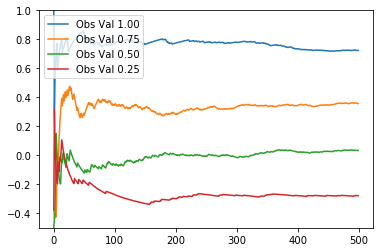

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


class Machine:
    def __init__(self):

        # array for storing reward values
        self.r = np.array([[-1, -10, -30,  -1],   # State S0
                           [-1,  -1, -30,  90],   # State S1
                           [-1,  -1,  -1,  -1],   # State S2
                           [-1,  -1,  -1,  -1]])  # State S3

        # current reward
        self.reward = -1

        # keep track of total reward
        self.total_reward = 0.0

        # list of states
        self.state_list = [0, 1, 2, 3]

        # belief state, all same to start
        self.belief_state = [0.3, 0.3, 0.3, 0.3]  # Choice to be made in s0 and s1

        # set up belief table
        self.belief_table = []

        for s0 in range(0, 11):
            for s1 in range (0, 11):
                for s2 in range (0, 11):
                    for s3 in range (0, 11):
                        self.belief_table.append([s0, s1, s2, s3, 0, 0])

        # convert to array
        self.belief_table = np.vstack(self.belief_table)

        # divide all by 10
        self.belief_table = self.belief_table/10.0

        # index of belief table corresponding to belief state
        self.belief_table_index = -1

        # index of belief table corresponding to previous belief state
        self.previous_belief_table_index = -1

        # keep track of real state
        self.real_state = -1

        # action number: 0 = Pull lever, 1 = Enter magazine
        self.action_number = -1

        # state to move to next
        self.next_state = -1

        # list to keep track of expected value
        self.expected_value_array = []

    def reset(self, initial_state):

        print "Reset"

        self.belief_state = [0.3, 0.3, 0.3, 0.3]
        self.real_state = initial_state

    def observe(self, observation_chance):

        rand_num = random.random()
        if rand_num < observation_chance:
            return self.real_state
        else:
            random_state = random.choice(self.state_list)

            while random_state == self.real_state:
                random_state = random.choice(self.state_list)

            return random_state

    def update_belief_state(self, observation_state, observation_chance):

        # Temporary list
        temp_belief_state = [0.0, 0.0, 0.0, 0.0]

        # Use Bayes' Rule to update belief state
        for n in range(len(temp_belief_state)):
            if observation_state == n:
                temp_belief_state[n] = observation_chance * self.belief_state[n]
            else:
                temp_belief_state[n] = ((1 - observation_chance)/(len(self.state_list) - 1)) * self.belief_state[n]

        # Normalise so the belief state sums to 1
        temp_total = sum(temp_belief_state)
        self.belief_state = list(n/temp_total for n in temp_belief_state)

        # Round to 1 decimal place
        self.belief_state = [round(n, 1) for n in self.belief_state]

    def choose_next_action(self, epsilon):

        # get the q_values of the two actions
        q_value_a0 = (self.belief_table[self.belief_table_index, 4])

        q_value_a1 = (self.belief_table[self.belief_table_index, 5])

        # choose an action using epsilon greedy
        rand_num = random.random()

        if q_value_a0 > q_value_a1:

            if rand_num > epsilon:
                self.action_number = 0  # Exploit

            else:
                self.action_number = 1  # Explore

        elif q_value_a1 > q_value_a0:

            if rand_num > epsilon:
                self.action_number = 1  # Exploit

            else:
                self.action_number = 0  # Explore

        else:
            self.action_number = random.randint(0, 1)

    # get corresponding next state from current state and action number
    def get_next_state(self):

        if self.real_state == 0:

            if self.action_number == 0:

                self.next_state = 1

            elif self.action_number == 1:

                self.next_state = 2

        elif self.real_state == 1:

            if self.action_number == 0:

                self.next_state = 2

            elif self.action_number == 1:

                self.next_state = 3

    def get_belief_table_index(self):

        self.belief_table_index = np.where((self.belief_table[:, 0] == self.belief_state[0])
                                           & (self.belief_table[:, 1] == self.belief_state[1])
                                           & (self.belief_table[:, 2] == self.belief_state[2])
                                           & (self.belief_table[:, 3] == self.belief_state[3]))[0]

    # get highest Q-value in belief state
    def calculate_max_q_value(self):

        # get the Q-values of the two actions
        q_value_a0 = self.belief_table[self.belief_table_index, 4]

        q_value_a1 = self.belief_table[self.belief_table_index, 5]

        # return the highest
        if q_value_a0 > q_value_a1:
            return q_value_a0
        else:
            return q_value_a1

    def update_belief_table(self, alpha, gamma):

        # get correct element index for the select action
        if self.action_number == 0:
            location = 4
        else:
            location = 5

        max_q_value = self.calculate_max_q_value()

        previous_q = self.belief_table[self.previous_belief_table_index, location]

        print "Real state: ", self.real_state
        print "Action number: ", self.action_number
        print "Max Q: ", max_q_value
        print "Reward: ", self.reward

        print "Before update: ", self.belief_table[self.previous_belief_table_index]

        # update Q-value
        self.belief_table[self.previous_belief_table_index, location] = previous_q + alpha * (self.reward + gamma * max_q_value - previous_q)

        # round to 1 decimal place
        self.belief_table[self.previous_belief_table_index, location] = round(self.belief_table[self.previous_belief_table_index, location], 1)

        print "After update: ", self.belief_table[self.previous_belief_table_index]

    def run_experiment(self, initial_state, observation_chance, alpha, gamma, epsilon, num_runs_wanted):

        # set current state to initial state wanted
        self.real_state = initial_state

        # make an initial run

        # make an observation
        observation = self.observe(observation_chance)

        # update belief state with observation
        self.update_belief_state(observation, observation_chance)

        # get the corresponding index in the belief table
        self.get_belief_table_index()

        # choose next action
        self.choose_next_action(epsilon)

        # get the next state
        self.get_next_state()

        # get the reward for moving from current state to next state
        self.reward = self.r[self.real_state][self.next_state]

        # update total reward
        self.total_reward += self.reward

        # move to the next state
        self.real_state = self.next_state
        self.belief_state = [0.3, 0.3, 0.3, 0.3]

        print "Real state update: ", self.real_state, " --> ", self.next_state

        # variables to keep track
        num_rewards_received = 0
        num_fails = 0

        num_runs = 0

        while num_runs < num_runs_wanted:

            print ""

            # make an observation
            observation = self.observe(observation_chance)

            # update belief state with observation
            self.update_belief_state(observation, observation_chance)

            # keep track of the previous belief_table_index
            self.previous_belief_table_index = self.belief_table_index

            # get the corresponding index in the belief table
            self.get_belief_table_index()

            print "Observation: ", observation

            # update the belief table using Q-learning
            self.update_belief_table(alpha, gamma)

            # if terminal state reached
            if self.real_state == 2 or self.real_state == 3:

                if self.real_state == 2:
                    num_fails += 1
                elif self.real_state == 3:
                    num_rewards_received += 1

                num_runs += 1

                self.expected_value_array = np.append(self.expected_value_array, self.total_reward / (80 * num_runs))

                # reset to inital values
                self.reset(initial_state)

                # make an observation
                observation = self.observe(observation_chance)

                # update belief state with observation
                self.update_belief_state(observation, observation_chance)

                print "Observation: ", observation

                # get the corresponding index in the belief table
                self.get_belief_table_index()

                # keep track of the previous belief_table_index
                self.previous_belief_table_index = self.belief_table_index

            # choose next action
            self.choose_next_action(epsilon)

            # get the next state
            self.get_next_state()

            # get the reward for moving from current state to next state
            self.reward = self.r[self.real_state][self.next_state]

            # update total reward
            self.total_reward += self.reward

            print "Real state update: ", self.real_state, " --> ", self.next_state

            # move to the next state
            self.real_state = self.next_state
            self.belief_state = [0.3, 0.3, 0.3, 0.3]

        print ""
        print "Number of fails:"
        print num_fails

        print ""
        print "Number of rewards:"
        print num_rewards_received

experiment_instance = Machine()
experiment_instance.run_experiment(0, 1.0, 0.1, 0.8, 0.1, 500)
expected_value_1p00 = experiment_instance.expected_value_array

experiment_instance = Machine()
experiment_instance.run_experiment(0, 0.75, 0.1, 0.8, 0.1, 500)
expected_value_0p75 = experiment_instance.expected_value_array

experiment_instance = Machine()
experiment_instance.run_experiment(0, 0.50, 0.1, 0.8, 0.1, 500)
expected_value_0p50 = experiment_instance.expected_value_array

experiment_instance = Machine()
experiment_instance.run_experiment(0, 0.25, 0.1, 0.8, 0.1, 500)
expected_value_0p25 = experiment_instance.expected_value_array


plt.plot(expected_value_1p00, label="Obs Val 1.00")  # plot the results, and give a label
plt.plot(expected_value_0p75, label="Obs Val 0.75")
plt.plot(expected_value_0p50, label="Obs Val 0.50")
plt.plot(expected_value_0p25, label="Obs Val 0.25")
plt.ylim(-0.5, 1)  # limits for the y-axis
plt.legend(loc='best')  # display the graph key
plt.savefig('expected_value_graph.png')  # save graph to folder
plt.show()  # display the graph

    experiment_instance = Machine()
    experiment_instance.run_experiment(0, 1.00, 0.1, 0.8, 0.1, 500)
    expected_value_1p00 = experiment_instance.expected_value_array

    experiment_instance = Machine()
    experiment_instance.run_experiment(0, 0.75, 0.1, 0.8, 0.1, 500)
    expected_value_0p75 = experiment_instance.expected_value_array

    experiment_instance = Machine()
    experiment_instance.run_experiment(0, 0.50, 0.1, 0.8, 0.1, 500)
    expected_value_0p50 = experiment_instance.expected_value_array

    experiment_instance = Machine()
    experiment_instance.run_experiment(0, 0.25, 0.1, 0.8, 0.1, 500)
    expected_value_0p25 = experiment_instance.expected_value_array
    
We generate and run instances of the experiment for observation values of 1.00, 0.75, 0.50, 0.25. We then assign the expected_value_array from each of the experiments to variables.

1p00 reads 'one point zero zero' (1.0), 0p75 reads 'zero point seven five' (0.75), etc.

    plt.plot(expected_value_1p00, label="EV 1.00")  # plot the results, and give a label
    plt.plot(expected_value_0p75, label="EV 0.75")
    plt.plot(expected_value_0p50, label="EV 0.50")
    plt.plot(expected_value_0p25, label="EV 0.25")
    plt.ylim(-0.5, 1)  # limits for the y-axis
    plt.legend(loc='best')  # display the graph key
    plt.savefig('expected_value_graph.png')  # save graph to folder
    plt.show()  # display the graph
    
We plot a graph with the expected values of each of the observation values. The code for plotting graphs is similar to the other two tutorials.

After running the code, the graph will be saved to the same folder as the notebook as 'expected_value_graph.png'. You should have a graph similar to this:

<img src="expected_value.png" width="800" height="800">

As you can see, the higher the observation value, the higher the expected value, as we would expect. 


Questions:

- 

### References:

Brown University. (1999), ‘Background on Solving POMDPs’, http://cs.brown.edu/research/ai/pomdp/tutorial/pomdp-solving.html. [Online; accessed 02 February 2017].

Daw, N. D., Niv, Y. and Dayan, P. (2005), ‘Uncertainty-based competition between pre- frontal and dorsolateral striatal systems for behavioral control’, Nature neuroscience 8(12), 1704–1711.

Sutton, R. S. and Barto, A. G. (1998), Reinforcement learning: An introduction, Vol. 1, MIT press Cambridge.